In [1]:
# Nainštalovanie potrebných knižníc

!pip3 install numpy pandas matplotlib opencv-python graphviz scikit-learn scikit-image sqlalchemy tensorflow keras

In [2]:
# Nainportovanie potrebných knižníc

import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import peak_local_max, corner_peaks
import sqlite3
from adspy_shared_utilities import plot_class_regions_for_classifier, plot_feature_importances, plot_decision_tree

# %matplotlib notebook

In [3]:
# Urobí si zoznam snímok

path = 'AAC_dataset/usable/'
files = [file for file in os.listdir(path) if file.endswith('.npy')]
image = np.load(path + files[0])

In [4]:
# Nacita si snimky z priecinka

new_height = 400
new_width = 400
data_path = 'AAC_dataset/'
class_mappings = {}

subfolders = [
    folder for folder in os.listdir(data_path) if not folder.startswith('.')]
X, y, timestamps = [], [], []
for i, subfolder in enumerate(subfolders):
    class_mappings[i] = subfolder
    files = [
        file for file in os.listdir(data_path + subfolder)
        if file.endswith('.npy')]
    for file in files:
        image = np.load(data_path + subfolder + '/' + file)
        image = cv2.resize(image, (new_width, new_height),
                           interpolation=cv2.INTER_AREA)
        X.append(image)
        y.append(i)
        parsed_ts = pd.to_datetime(file.split('.')[0][4:],
                                   format='%Y-%m-%d_%H-%M-%S')
        timestamps.append(parsed_ts)

X = np.array(X)
y = np.array(y)

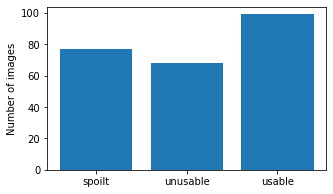

In [5]:
# Urobi histogram s pocetnostou v jednotlivych typoch

class_ids, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(5, 3))
plt.bar([class_mappings[class_id] for class_id in class_ids], counts)
plt.ylabel('Number of images')
plt.show()

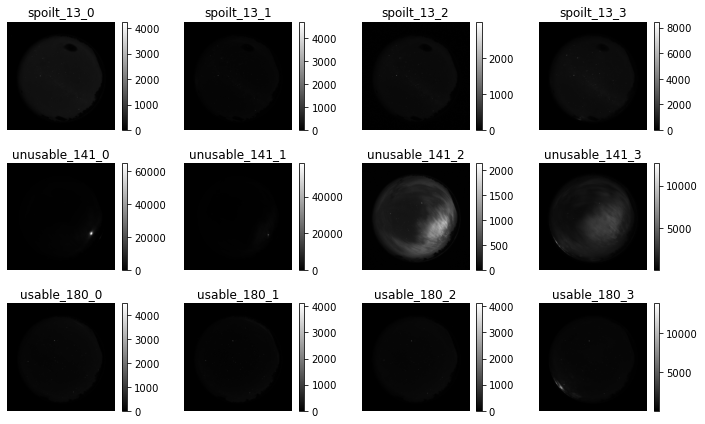

In [6]:
# Zobrazy classes - raw images

fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=4)

for class_id, class_name in class_mappings.items():
    class_subset = np.where(y == class_id)[0]
    rnd_idx = np.random.choice(class_subset)

    for j in range(4):
        im = axs[class_id, j].imshow(X[rnd_idx, :, :, j], cmap='gray')
        fig.colorbar(im, ax=axs[class_id, j])
        axs[class_id, j].set_title(class_name + '_' + str(rnd_idx) + '_' + str(j))
        axs[class_id, j].axis('off')
plt.tight_layout()

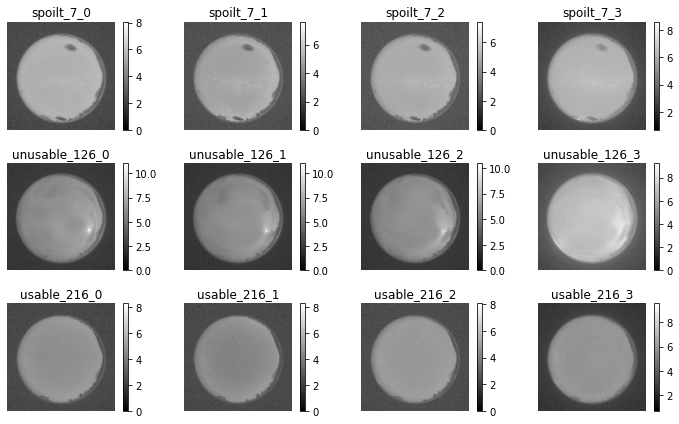

In [7]:
# Zobrazy classes - log images

fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=4)

for class_id, class_name in class_mappings.items():
    class_subset = np.where(y == class_id)[0]
    rnd_idx = np.random.choice(class_subset)

    for j in range(4):
        im = axs[class_id, j].imshow(np.log(1 + X[rnd_idx, :, :, j]), cmap='gray')
        fig.colorbar(im, ax=axs[class_id, j])
        axs[class_id, j].set_title(class_name + '_' + str(rnd_idx) + '_' + str(j))
        axs[class_id, j].axis('off')
plt.tight_layout()

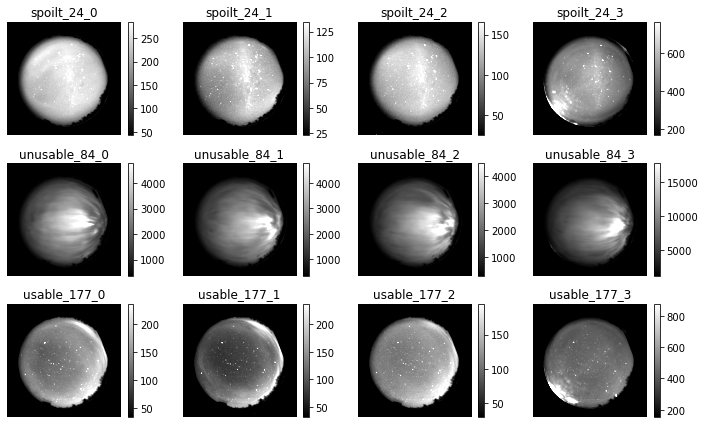

In [8]:
# Zobrazy classes - quantile images

fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=4)

for class_id, class_name in class_mappings.items():
    class_subset = np.where(y == class_id)[0]
    rnd_idx = np.random.choice(class_subset)

    for j in range(4):
        X_slice = X[rnd_idx, :, :, j]
        im = axs[class_id, j].imshow(X_slice,
                                     cmap='gray',
                                     vmin=np.percentile(X_slice, 50),
                                     vmax=np.percentile(X_slice, 99))
        fig.colorbar(im, ax=axs[class_id, j])
        axs[class_id, j].set_title(class_name + '_' + str(rnd_idx) + '_' + str(j))
        axs[class_id, j].axis('off')
plt.tight_layout()

# Praca na analýze

In [9]:
# Vytvorenie roznych zakladnych features - NEW

X1, Y1 = np.meshgrid(np.arange(-200, 200), np.arange(-200, 200))
dist = X1**2 + Y1**2
mask = np.zeros((400, 400))
mask[dist < 160**2] = 1
mask = mask.astype(bool)

feats = pd.DataFrame()
feats['timestamp'] = timestamps

feats['max'] = [img_set[mask].max() for img_set in X]
feats['mean'] = [img_set[mask].mean() for img_set in X]
feats['std'] = [img_set[mask].std() for img_set in X]

for i in range(4):
    feats['max_' + str(i)] = [img_set[mask, i].max() for img_set in X]
    feats['mean_' + str(i)] = [img_set[mask, i].mean() for img_set in X]
    feats['std_' + str(i)] = [img_set[mask, i].std() for img_set in X]

for i in range(3):
    feats['max_' + str(4) + "-" + str(i)] = [(img_set[mask, 3]-img_set[mask, i]).max() for img_set in X]
    feats['mean_' + str(4) + "-" + str(i)] = [(img_set[mask, 3]-img_set[mask, i]).mean() for img_set in X]
    feats['std_' + str(4) + "-" + str(i)] = [(img_set[mask, 3]-img_set[mask, i]).std() for img_set in X]
    
for i in range(2):
    feats['max_' + str(3) + "-" + str(i)] = [(img_set[mask, 2]-img_set[mask, i]).max() for img_set in X]
    feats['mean_' + str(3) + "-" + str(i)] = [(img_set[mask, 2]-img_set[mask, i]).mean() for img_set in X]
    feats['std_' + str(3) + "-" + str(i)] = [(img_set[mask, 2]-img_set[mask, i]).std() for img_set in X]
    
for i in range(1):
    feats['max_' + str(2) + "-" + str(i)] = [(img_set[mask, 1]-img_set[mask, i]).max() for img_set in X]
    feats['mean_' + str(2) + "-" + str(i)] = [(img_set[mask, 1]-img_set[mask, i]).mean() for img_set in X]
    feats['std_' + str(2) + "-" + str(i)] = [(img_set[mask, 1]-img_set[mask, i]).std() for img_set in X]
    
feats

,timestamp,max,mean,std,max_0,mean_0,std_0,max_1,mean_1,std_1,...,std_4-2,max_3-0,mean_3-0,std_3-0,max_3-1,mean_3-1,std_3-1,max_2-0,mean_2-0,std_2-0
0,2019-10-01 20:09:07,10183,320.921506,220.576092,2303,424.047419,119.587753,1308,146.252697,69.285878,...,436.290515,65535,65204.847167,1826.404548,65535,24603.064540,31705.702652,65535,65165.245256,2456.698599
1,2019-10-01 20:43:20,10539,305.942456,219.839436,2260,388.510595,113.766587,1304,132.664771,53.718522,...,875.659135,65535,65140.170451,3041.318629,65535,22400.375269,31060.594770,65535,65150.499409,2899.291153
2,2019-10-23 17:26:08,3491,295.798828,205.280540,3491,311.909306,88.372765,2790,140.573219,48.736880,...,527.624517,65535,65155.639612,3745.502634,65535,17652.346925,29054.900506,65535,65138.787368,3827.374719
3,2019-10-23 17:52:02,4948,288.244463,198.775089,3205,305.569088,86.173881,2807,139.906121,47.579773,...,658.912492,65535,65167.299494,3652.772445,65535,23597.989822,31443.512664,65535,65146.906805,3807.442288
4,2019-10-23 18:17:55,3414,284.352521,197.199927,3159,292.988217,83.188610,2375,139.327104,46.366061,...,618.038206,65535,65182.493909,3631.625710,65535,24040.703891,31567.875474,65535,65126.291107,4075.829657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2020-05-21 22:29:04,11048,219.195427,164.462317,4301,221.508305,65.128937,2773,81.874019,35.336375,...,946.254849,65535,65142.161045,4358.252844,65535,3839.298050,15303.822098,65535,65177.828118,3763.886443
240,2020-05-21 22:58:20,9099,221.860864,167.939802,4563,226.688524,67.877454,3310,83.461546,36.978915,...,889.430299,65535,65130.110652,4381.804734,65535,4618.554219,16703.277955,65535,65150.587702,3961.889471
241,2020-05-21 23:27:05,12044,221.801285,176.726199,3545,221.721522,66.511505,4384,83.951835,39.548872,...,995.994595,65535,65126.179422,4392.343918,65535,6777.417437,19907.977409,65535,65173.169207,3818.087271
242,2020-05-21 23:56:30,12640,216.508713,177.907472,5593,212.684182,69.562384,4033,84.113987,43.843132,...,996.899918,65535,65112.871194,4510.106416,65535,8353.169742,21819.705859,65535,65139.965882,4160.974075


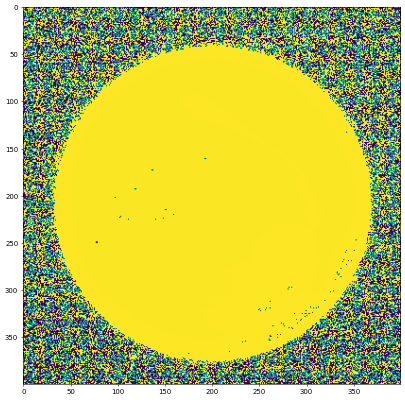

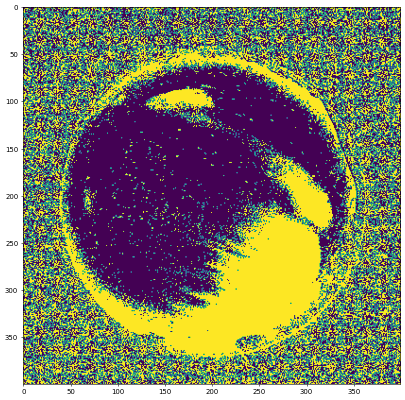

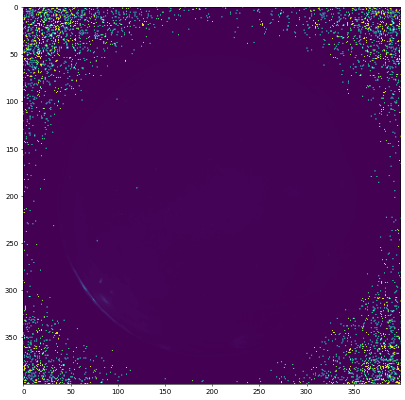

In [10]:
# Experimenotvanie s obrazom

for i in range(1, 4):
    plt.figure(figsize=(10, 10), dpi=50)
    img_set = X[0]
    plt.imshow(img_set[:, :, i]-img_set[:, :, i-1])
    plt.show()

In [11]:
# Zvysi kontrast vsetkych snimok

X_transf = []
for img_set in X:
    X_transf_1 = img_set.astype(float)
    for j in range(4):
        X_slice = X_transf_1[:, :, j]
        p1 = np.percentile(X_slice, 50)
        p2 = np.percentile(X_slice, 99)
        X_slice[X_slice <= p1] = p1
        X_slice[X_slice >= p2] = p2
        X_slice -= X_slice.min()
        X_slice /= X_slice.max()
    X_transf.append(X_transf_1)
X_transf = np.array(X_transf)

547


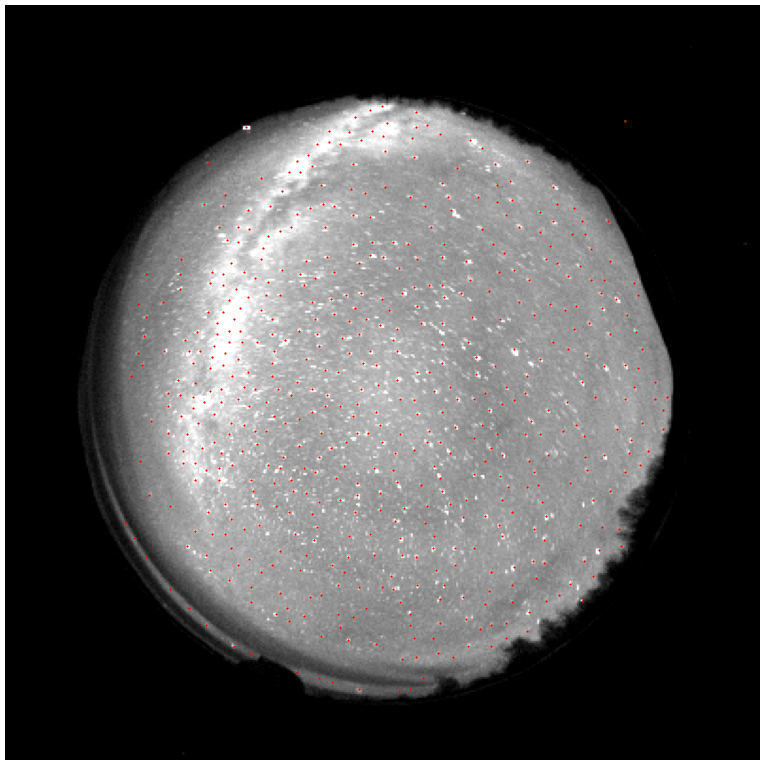

In [12]:
# Ukaze a oznaci hviezdy na ukazkovom obrazku

test_img = X_transf[210, :, :, 3]
# coordinates = peak_local_max(test_img, min_distance=10, threshold_abs=0.3)
coordinates = corner_peaks(test_img, min_distance=5, threshold_abs=0.3)
print(len(coordinates))

plt.figure(figsize=(20, 20), dpi=50)
plt.imshow(test_img, cmap='gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.', markersize=4)
plt.axis('off')
plt.show()

In [13]:
# Ako dalsiu featuru da pocet hviezd na obrazku

nb_peaks = []
for img_set in X_transf:
    peak_sum = 0
    for j in range(4):
        peak_sum += len(corner_peaks(img_set[:, :, j], min_distance=5, threshold_abs=0.3))
    nb_peaks.append(peak_sum)

feats['nb_peaks'] = nb_peaks

y_onehot = to_categorical(y)
feats['y_unusable'] = y_onehot[:, 0].astype(int)
feats['y_spoilt'] = y_onehot[:, 1].astype(int)
feats['y_usable'] = y_onehot[:, 2].astype(int)

feats

,timestamp,max,mean,std,max_0,mean_0,std_0,max_1,mean_1,std_1,...,max_3-1,mean_3-1,std_3-1,max_2-0,mean_2-0,std_2-0,nb_peaks,y_unusable,y_spoilt,y_usable
0,2019-10-01 20:09:07,10183,320.921506,220.576092,2303,424.047419,119.587753,1308,146.252697,69.285878,...,65535,24603.064540,31705.702652,65535,65165.245256,2456.698599,1906,1,0,0
1,2019-10-01 20:43:20,10539,305.942456,219.839436,2260,388.510595,113.766587,1304,132.664771,53.718522,...,65535,22400.375269,31060.594770,65535,65150.499409,2899.291153,2053,1,0,0
2,2019-10-23 17:26:08,3491,295.798828,205.280540,3491,311.909306,88.372765,2790,140.573219,48.736880,...,65535,17652.346925,29054.900506,65535,65138.787368,3827.374719,2179,1,0,0
3,2019-10-23 17:52:02,4948,288.244463,198.775089,3205,305.569088,86.173881,2807,139.906121,47.579773,...,65535,23597.989822,31443.512664,65535,65146.906805,3807.442288,2136,1,0,0
4,2019-10-23 18:17:55,3414,284.352521,197.199927,3159,292.988217,83.188610,2375,139.327104,46.366061,...,65535,24040.703891,31567.875474,65535,65126.291107,4075.829657,2133,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2020-05-21 22:29:04,11048,219.195427,164.462317,4301,221.508305,65.128937,2773,81.874019,35.336375,...,65535,3839.298050,15303.822098,65535,65177.828118,3763.886443,2314,0,0,1
240,2020-05-21 22:58:20,9099,221.860864,167.939802,4563,226.688524,67.877454,3310,83.461546,36.978915,...,65535,4618.554219,16703.277955,65535,65150.587702,3961.889471,2286,0,0,1
241,2020-05-21 23:27:05,12044,221.801285,176.726199,3545,221.721522,66.511505,4384,83.951835,39.548872,...,65535,6777.417437,19907.977409,65535,65173.169207,3818.087271,2321,0,0,1
242,2020-05-21 23:56:30,12640,216.508713,177.907472,5593,212.684182,69.562384,4033,84.113987,43.843132,...,65535,8353.169742,21819.705859,65535,65139.965882,4160.974075,2296,0,0,1


In [14]:
# Zobrazi korelacie

feats.corr().round(2)

,max,mean,std,max_0,mean_0,std_0,max_1,mean_1,std_1,max_2,...,max_3-1,mean_3-1,std_3-1,max_2-0,mean_2-0,std_2-0,nb_peaks,y_unusable,y_spoilt,y_usable
max,1.00,0.63,0.72,0.90,0.63,0.75,0.89,0.64,0.74,0.87,...,NaN,0.32,-0.33,NaN,-0.03,0.07,-0.54,-0.26,0.41,-0.13
mean,0.63,1.00,0.95,0.55,0.99,0.86,0.52,1.00,0.85,0.55,...,NaN,0.57,-0.22,NaN,-0.20,0.17,-0.75,-0.21,0.57,-0.32
std,0.72,0.95,1.00,0.67,0.94,0.95,0.69,0.96,0.96,0.70,...,NaN,0.60,-0.33,NaN,-0.16,0.13,-0.77,-0.24,0.59,-0.32
max_0,0.90,0.55,0.67,1.00,0.58,0.79,0.86,0.57,0.72,0.84,...,NaN,0.32,-0.41,NaN,0.06,-0.02,-0.53,-0.22,0.37,-0.13
mean_0,0.63,0.99,0.94,0.58,1.00,0.88,0.52,0.99,0.85,0.57,...,NaN,0.59,-0.25,NaN,-0.13,0.10,-0.78,-0.17,0.57,-0.36
std_0,0.75,0.86,0.95,0.79,0.88,1.00,0.74,0.88,0.95,0.76,...,NaN,0.60,-0.40,NaN,-0.07,0.07,-0.78,-0.24,0.59,-0.31
max_1,0.89,0.52,0.69,0.86,0.52,0.74,1.00,0.54,0.79,0.92,...,NaN,0.36,-0.42,NaN,0.01,-0.01,-0.56,-0.20,0.39,-0.16
mean_1,0.64,1.00,0.96,0.57,0.99,0.88,0.54,1.00,0.87,0.57,...,NaN,0.61,-0.26,NaN,-0.21,0.20,-0.78,-0.23,0.60,-0.33
std_1,0.74,0.85,0.96,0.72,0.85,0.95,0.79,0.87,1.00,0.78,...,NaN,0.61,-0.46,NaN,-0.10,0.07,-0.76,-0.24,0.58,-0.30
max_2,0.87,0.55,0.70,0.84,0.57,0.76,0.92,0.57,0.78,1.00,...,NaN,0.36,-0.44,NaN,0.04,-0.02,-0.55,-0.18,0.37,-0.17


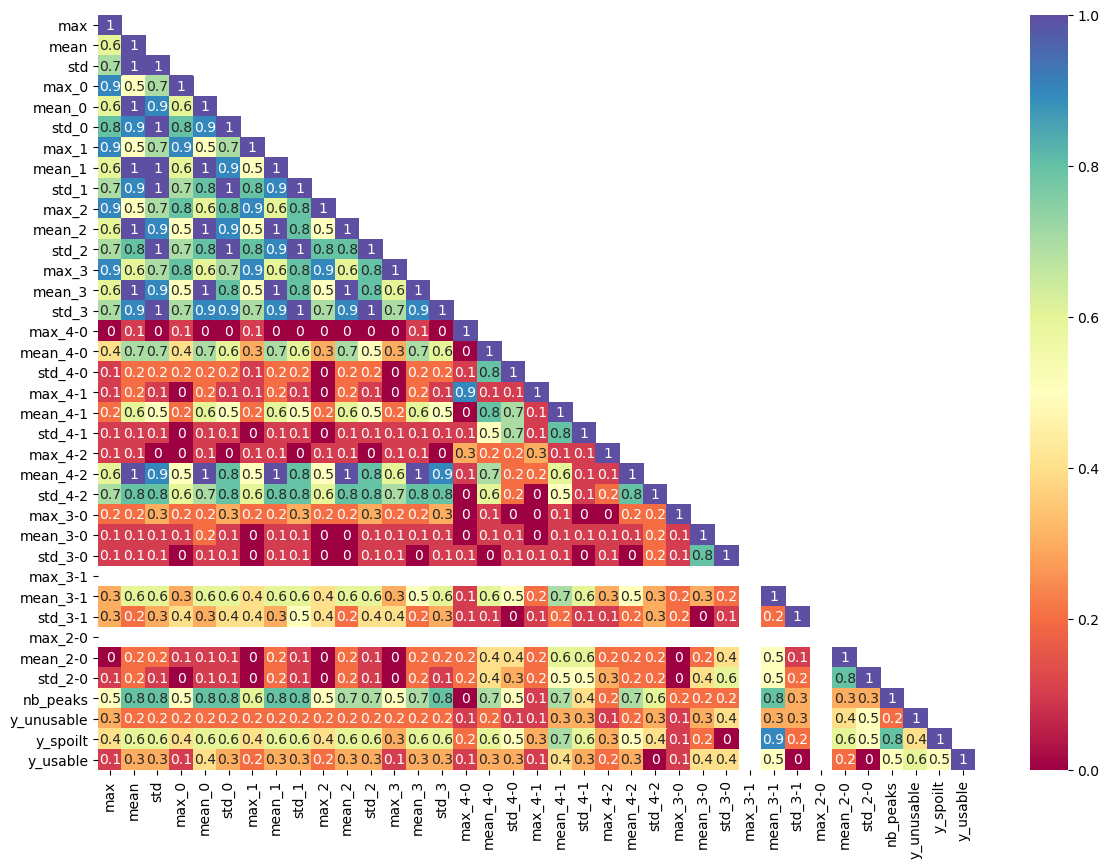

In [15]:
# Zobrazi pekne vsetky korelacie

np.tril(np.ones(feats.corr().round(1).shape)).astype(np.bool)[0:feats.shape[1], 0:feats.shape[1]]
df_feats = abs(feats.corr().round(1).where(np.tril(np.ones(feats.corr().round(1).shape)).astype(np.bool)))

fig, ax = plt.subplots(figsize=((2**0.5)*10,10), dpi=100)         # Sample figsize in inches

hmap = sns.heatmap(df_feats, cmap="Spectral", annot=True, ax=ax)
hmap

In [16]:
feats_final = feats[['timestamp', 'mean', 'std', 'mean_4-1', 'nb_peaks']].copy()
feats_final['y'] = y
feats_final = feats_final.sort_values(by='timestamp')
feats_final

,timestamp,mean,std,mean_4-1,nb_peaks,y
0,2019-10-01 20:09:07,320.921506,220.576092,430.204930,1906,0
1,2019-10-01 20:43:20,305.942456,219.839436,452.486506,2053,0
2,2019-10-23 17:26:08,295.798828,205.280540,455.546392,2179,0
3,2019-10-23 17:52:02,288.244463,198.775089,437.468949,2136,0
4,2019-10-23 18:17:55,284.352521,197.199927,436.288295,2133,0
...,...,...,...,...,...,...
239,2020-05-21 22:29:04,219.195427,164.462317,393.130336,2314,2
240,2020-05-21 22:58:20,221.860864,167.939802,398.229790,2286,2
241,2020-05-21 23:27:05,221.801285,176.726199,416.584205,2321,2
242,2020-05-21 23:56:30,216.508713,177.907472,411.794622,2296,2


In [17]:
# train/test split
X_train = feats_final.iloc[:180, 1:5].copy()
X_test = feats_final.iloc[180:, 1:5].copy()
y_train = feats_final.iloc[:180, 5].copy()
y_test = feats_final.iloc[180:, 5].copy()

In [18]:
# normalize features
for col in X_train.columns:    
    intercept = X_train[col].min()
    scale = (X_train[col] - intercept).max()
    X_train[col] = (X_train[col] - intercept) / scale
    X_test[col] = (X_test[col] - intercept) / scale

## Lineárna regresia

In [19]:
%matplotlib notebook

lr = LogisticRegression(C=4)
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.8277777777777777
0.640625


In [20]:
feat_subset = [0, 1]
feature_names = list(X_train.columns[feat_subset])
X_subset_tr = X_train.values[:, feat_subset].copy()
X_subset_te = X_test.values[:, feat_subset].copy()

lr = LogisticRegression(C=10)
lr.fit(X_subset_tr, y_train)
print(lr.score(X_subset_tr, y_train))
print(lr.score(X_subset_te, y_test))

0.6222222222222222
0.390625


In [21]:
plot_class_regions_for_classifier(lr,
                                  X_subset_tr, 
                                  y_train.values, 
                                  X_test=X_subset_te, 
                                  y_test=y_test.values, 
                                  title='Logistic regression',
                                  target_names=list(class_mappings.values()),
                                  feature_names=feature_names)

<IPython.core.display.Javascript object>

## K-susedia 

In [22]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.8777777777777778
0.671875


In [23]:
feat_subset = [0, 1]
feature_names = list(X_train.columns[feat_subset])
X_subset_tr = X_train.values[:, feat_subset].copy()
X_subset_te = X_test.values[:, feat_subset].copy()

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_subset_tr, y_train)
print(knn.score(X_subset_tr, y_train))
print(knn.score(X_subset_te, y_test))

0.9444444444444444
0.25


In [24]:
plot_class_regions_for_classifier(knn, 
                                  X_subset_tr, 
                                  y_train.values, 
                                  X_test=X_subset_te, 
                                  y_test=y_test.values, 
                                  title='K nearest neighbours',
                                  target_names=list(class_mappings.values()),
                                  feature_names=feature_names)

<IPython.core.display.Javascript object>

## STROM

In [25]:
dt4 = DecisionTreeClassifier(max_depth=5)
dt4.fit(X_train, y_train)
print(dt4.score(X_train, y_train))
print(dt4.score(X_test, y_test))

0.9611111111111111
0.6875


In [26]:
plot_feature_importances(dt4, X_train.columns)

<IPython.core.display.Javascript object>

In [27]:
feat_subset = [0, 1]
feature_names = list(X_train.columns[feat_subset])
X_subset_tr = X_train.values[:, feat_subset].copy()
X_subset_te = X_test.values[:, feat_subset].copy()

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_subset_tr, y_train)
print(dt.score(X_subset_tr, y_train))
print(dt.score(X_subset_te, y_test))

0.9444444444444444
0.359375


In [28]:
plot_class_regions_for_classifier(dt, 
                                  X_subset_tr, 
                                  y_train.values, 
                                  X_test=X_subset_te, 
                                  y_test=y_test.values, 
                                  title='DecisionTreeClassifier',
                                  target_names=list(class_mappings.values()),
                                  feature_names=feature_names)

<IPython.core.display.Javascript object>

In [29]:
rf = RandomForestClassifier(max_depth=4, n_estimators=200)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9111111111111111
0.609375
